Starting RBMK simulation suite...
--- Running scenario: Baseline ---
Saved CSV -> scenarioA_Baseline.csv
--- Running scenario: Delayed SCRAM ---
Saved CSV -> scenarioB_Delayed_SCRAM.csv
--- Running scenario: High Void Coef ---
Saved CSV -> scenarioC_High_Void_Coef.csv
--- Running scenario: Graphite Tip Strong ---
Saved CSV -> scenarioD_Graphite_Tip_Strong.csv
... All scenarios complete.


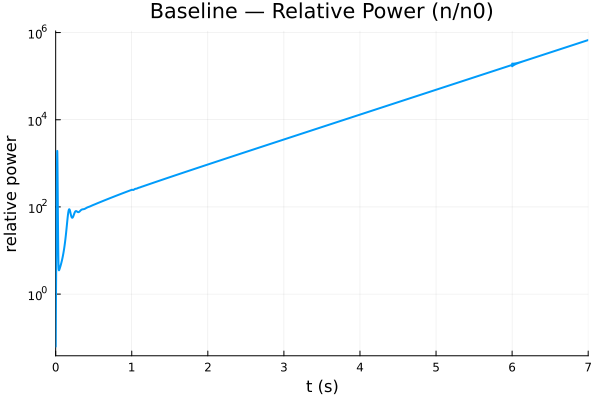

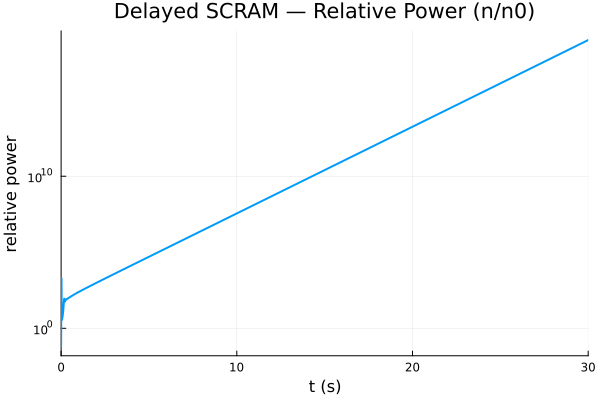

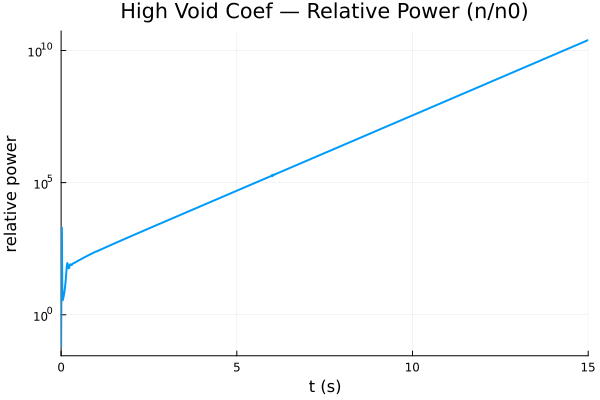

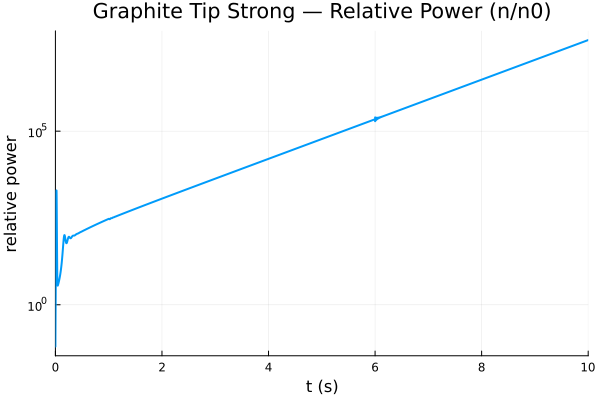

In [ ]:
# ==============================================================================
#      RBMK-1000 CHERNOBYL ACCIDENT SIMULATION (V2 - Mutable Struct Fix)
#      -------------------------------------------------------------
# This Julia script simulates the RBMK-1000 reactor kinetics and thermal-hydraulics
# during the Chernobyl accident using a system of ODEs. It includes multiple scenarios
# to illustrate different reactor behaviors under various conditions.
# ==============================================================================

# --- 1. Import Necessary Packages ---
using DifferentialEquations
using Plots
using DelimitedFiles

# --- 2. Define Reactor Parameters Struct ---
# We use "mutable struct" so we can change parameters for different scenarios.
Base.@kwdef mutable struct ReactorParams
    # --- Neutronics & kinetics
    Λ::Float64 = 2e-5            # neutron generation time (s)
    β::Float64 = 0.0055          # total delayed neutron fraction
    β_fractions::Vector{Float64} = [0.033, 0.219, 0.196, 0.395, 0.115, 0.042] .* 0.0055
    λ_precursors::Vector{Float64} = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01]
    Σ_f::Float64 = 0.1           # macroscopic fission cross-section (scaling)
    P0::Float64 = 3200e6        # nominal thermal power (W) (scale only)

    # --- Isotopes (Iodine/Xenon)
    γ_I::Float64 = 0.062
    γ_X::Float64 = 0.002
    λ_I::Float64 = 2.9e-5
    λ_X::Float64 = 2.1e-5
    σ_aX::Float64 = 2.65e-18    # xenon absorption cross-section (toy)

    # --- Thermal-hydraulics
    κ::Float64 = 3.5e7          # heat transfer coeff (W / K) (toy)
    C_f::Float64 = 2e7          # fuel thermal capacitance (J / K)
    C_c::Float64 = 4e7          # coolant thermal capacitance (J / K)
    T_f0::Float64 = 450.0       # reference fuel temp (K)
    T_c0::Float64 = 520.0       # reference coolant temp (K)

    # --- Feedback coefficients
    α_f::Float64 = -1.0e-5      # fuel temperature coefficient (Δρ per K)
    α_c::Float64 = +4.5e-5      # coolant temperature coefficient (Δρ per K) (toy)
    α_void::Float64 = 0.0       # void coefficient (Δρ per fractional void); 0=off

    # --- Control rod / reactivity insertion model
    rod_total_worth::Float64 = 3.0 * 0.0055   # total initial rod worth (in Δβ units)
    rod_action_time::Float64 = 1.0            # time when rod action starts (s)
    rod_insertion_duration::Float64 = 5.0     # duration of insertion (s)
    graphite_tip_effect::Float64 = 1.0 * 0.0055 # graphite tip transient worth (Δβ units)
    rod_profile::Function = (p,t)->begin
        # Default rod profile: piecewise linear insertion starting at rod_action_time
        t0 = p.rod_action_time
        d = p.rod_insertion_duration
        if t < t0
            return p.rod_total_worth + p.graphite_tip_effect * (t / t0)
        elseif t < t0 + d
            frac = (t - t0)/d
            return p.rod_total_worth * (1.0 - frac) + p.graphite_tip_effect
        else
            return 0.0
        end
    end

    # --- Numerical / output options
    save_csv::Bool = true
    csv_prefix::String = "scenario"
    X0::Float64 = 0.0 # Placeholder for initial Xenon, will be set by run_scenario
end

# --- 3. The Core ODE System ---
function reactor_kinetics!(du, u, p::ReactorParams, t)
    # Unpack state
    n_rel = u[1]
    C_rel = @view u[2:7]
    I = u[8]
    X = u[9]
    T_f = u[10]
    T_c = u[11]

    # Reactivity components
    ρ_control = p.rod_profile(p, t)
    ρ_feedback = p.α_f * (T_f - p.T_f0) + p.α_c * (T_c - p.T_c0)
    
    ΔT_for_void = 100.0
    void_frac = clamp((T_f - p.T_f0)/ΔT_for_void, 0.0, 1.0)
    ρ_void = p.α_void * void_frac
    
    φ0_scale = 1e13 * (200.0 / 3200.0)
    φ = n_rel * φ0_scale
    ρ_xenon = -p.σ_aX * (X - p.X0) / max(p.Σ_f, eps())

    ρ_total = ρ_control + ρ_feedback + ρ_void + ρ_xenon

    # Point kinetics equations
    sum_precursors = sum(p.λ_precursors .* C_rel)
    du[1] = ((ρ_total - p.β) / p.Λ) * n_rel + sum_precursors
    for i in 1:6
        du[i+1] = (p.β_fractions[i] / p.Λ) * n_rel - p.λ_precursors[i] * C_rel[i]
    end

    # Iodine / Xenon kinetics
    du[8] = p.γ_I * p.Σ_f * φ - p.λ_I * I
    du[9] = p.γ_X * p.Σ_f * φ + p.λ_I * I - p.λ_X * X - p.σ_aX * X * φ

    # Simple thermal model
    power_generated = n_rel * p.P0
    power_transferred = p.κ * (T_f - T_c)
    du[10] = (power_generated - power_transferred) / p.C_f
    power_removed = 2 * p.κ * (T_c - p.T_c0)
    du[11] = (power_transferred - power_removed) / p.C_c
end

# --- 4. Helper function to build initial conditions ---
function build_u0(p::ReactorParams; power_fraction=200.0/3200.0)
    u0 = zeros(11)
    u0[1] = power_fraction
    for i in 1:6
        u0[i+1] = (p.β_fractions[i] / (p.Λ * p.λ_precursors[i])) * power_fraction
    end
    φ_half_power = 1e13 * 0.5
    I_half_power = p.γ_I * p.Σ_f * φ_half_power / p.λ_I
    X_half_power = (p.γ_X * p.Σ_f * φ_half_power + p.λ_I * I_half_power) / (p.λ_X + p.σ_aX * φ_half_power)
    u0[8] = I_half_power
    u0[9] = X_half_power
    u0[10] = p.T_f0
    u0[11] = p.T_c0
    return u0
end

# --- 5. Main function to run a single scenario ---
function run_scenario(name::String, p::ReactorParams; tspan=(0.0,7.0), reltol=1e-8, abstol=1e-8)
    println("--- Running scenario: $name ---")
    u0 = build_u0(p)
    
    # Pass the initial Xenon value into the params for this run
    p.X0 = u0[9]

    prob = ODEProblem(reactor_kinetics!, u0, tspan, p)
    sol = solve(prob, Rodas5P(), reltol=reltol, abstol=abstol)

    # Plot key outputs
    plt1 = plot(sol, idxs=1, title="$name — Relative Power (n/n0)", xlabel="t (s)", ylabel="relative power", lw=2, yaxis=:log10, legend=false)
    display(plt1)

    # Save CSV
    if p.save_csv
        header = ["t", "n_rel", "C1", "C2", "C3", "C4", "C5", "C6", "I", "X", "T_f", "T_c"]
        data = hcat(sol.t, permutedims(Array(sol)))
        fname = "$(p.csv_prefix)_$(replace(name,' '=>'_')).csv"
        
        try
            open(fname, "w") do f
                writedlm(f, [header], ',')
                writedlm(f, data, ',')
            end
            println("Saved CSV -> $fname")
        catch e
            println("ERROR: Could not write CSV file. Check permissions. Error: $e")
        end
    end

    return sol
end

# --- 6. Function to define and run all experiments ---
function run_all_examples()
    base = ReactorParams()

    # Scenario A: Baseline
    pA = deepcopy(base)
    pA.csv_prefix = "scenarioA" # Change prefix for this scenario

    # Scenario B: Delayed SCRAM
    pB = deepcopy(base)
    pB.rod_insertion_duration = 20.0 # Make insertion take longer
    pB.csv_prefix = "scenarioB"

    # Scenario C: Strong positive void coefficient
    pC = deepcopy(base)
    pC.α_void = 2.0e-4 # Enable the simple void model
    pC.csv_prefix = "scenarioC"

    # Scenario D: More aggressive graphite tip effect
    pD = deepcopy(base)
    pD.graphite_tip_effect = 2.0 * pD.β # Double the positive spike
    pD.csv_prefix = "scenarioD"

    # Run all scenarios
    sols = Dict{String,Any}()
    sols["Baseline"] = run_scenario("Baseline", pA, tspan=(0.0,7.0))
    sols["DelayedSCRAM"] = run_scenario("Delayed SCRAM", pB, tspan=(0.0,30.0))
    sols["HighVoid"] = run_scenario("High Void Coef", pC, tspan=(0.0,15.0))
    sols["GraphiteTipStrong"] = run_scenario("Graphite Tip Strong", pD, tspan=(0.0,10.0))

    return sols
end

# --- 7. Main execution block ---
println("Starting RBMK simulation suite...")
sols = run_all_examples()
println("... All scenarios complete.")